# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Lab 8: 11-Oct-2022
## Neural Machine Translation
In this lab, we explore how to implement Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

In [ ]:
# Match PyTorch version for pre-trained models - needs python <= 3.7
# !conda install pytorch==1.2.0 -c pytorch # OR
!pip install torch==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.9 MB 657 bytes/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.2.0 which is incompatible.


In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/2020.1011/Fall 2020: DS-GA 1011 | Final Lab Material/08-20201023

[Errno 2] No such file or directory: '/content/drive/My Drive/2020.1011/Fall 2020: DS-GA 1011 | Final Lab Material/08-20201023'
/content


In [ ]:
# For jupyter-notebook users
import sys

path_to_utils = 'pyfiles'
sys.path.append(path_to_utils)

In [ ]:
for p in sys.path:
  print(p)

/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload

/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
pyfiles


In [ ]:
# Import required packages
import torch
# import torch.nn as nn
# from torch import optim
# import torch.nn.functional as F
from torch.utils.data import DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import time
from tqdm import notebook
from functools import partial

In [ ]:
torch.__version__

'1.2.0'

c.f.
> `torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. [`ReduceLROnPlateau`](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.

> `tqdm.notebook` is a IPython/Jupyter Notebook progress bar decorator for iterators.

> `functools.partial` is used for partial function application which “freezes” some portion of a function’s arguments and/or keywords resulting in a new object with a simplified signature.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PAD_IDX = 0
UNK_IDX = 1 
SOS_IDX = 2
EOS_IDX = 3
SEP_IDX = 4

PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>' 
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
SEP_TOKEN = '<sep>'  # separates utterances in the dialogue history

NEAR_INF = 1e20  # approximates infinity for attention masking, scoring masking in beam

In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
from torch.utils.data import Dataset
import unicodedata
import re

from collections import namedtuple

import torch


class Lang:
	def __init__(self, name, minimum_count = 5):
		self.name = name
		self.word2index = {}
		self.word2count = {}
		self.index2word = [None]*4
		self.index2word[SOS_IDX] = SOS_TOKEN
		self.index2word[EOS_IDX] = EOS_TOKEN
		self.index2word[UNK_IDX] = UNK_TOKEN
		self.index2word[PAD_IDX] = PAD_TOKEN

		self.word2count[SOS_TOKEN] = 100;
		self.word2count[EOS_TOKEN] = 100;
		self.word2count[UNK_TOKEN] = 100;
		self.word2count[PAD_TOKEN] = 100;

		self.word2index[SOS_TOKEN] = SOS_IDX;
		self.word2index[EOS_TOKEN] = EOS_IDX;
		self.word2index[UNK_TOKEN] = UNK_IDX;
		self.word2index[PAD_TOKEN] = PAD_IDX;
		self.n_words = 4  # Count SOS and EOS

		self.minimum_count = minimum_count;

	def addSentence(self, sentence):
		for word in sentence.split(' '):
			self.addWord( word.lower() )

	def addWord(self, word):
		if word not in self.word2count.keys():
			self.word2count[word] = 1
		else:
			self.word2count[word] += 1
			
		if self.word2count[word] >= self.minimum_count:
			if word not in self.index2word:
				word = str(word);
				self.word2index[word] = self.n_words
				self.index2word.append(word)
				self.n_words += 1

	def vec2txt(self, list_idx):
		word_list = []
		if type(list_idx) == list:
			for i in list_idx:
				if i not in [EOS_IDX, SOS_IDX, PAD_IDX]:
					word_list.append(self.index2word[i])
		else:
			for i in list_idx:
				if i.item() not in [EOS_IDX,SOS_IDX,PAD_IDX]:
					word_list.append(self.index2word[i.item()])
		return (' ').join(word_list)

	def txt2vec(self, sentence):
		token_list = sentence.lower().split();
		index_list = [self.word2index[token] if token in self.word2index else UNK_IDX for token in token_list]
		return torch.from_numpy(np.array(index_list)).to(device)


def read_dataset(file):
	f = open(file)
	list_l = []
	for line in f:
		list_l.append(line.strip())
	df = pd.DataFrame()
	df['data'] = list_l
	return df


def token2index_dataset(df, source_lang_obj, target_lang_obj):
	for lan in ['source','target']:
		indices_data = []
		if lan=='source':
			lang_obj = source_lang_obj
		else:
			lang_obj = target_lang_obj
			
		for tokens in df[lan+'_tokenized']:
			
			index_list = [lang_obj.word2index[token] if token in lang_obj.word2index else UNK_IDX for token in tokens]
			index_list.append(EOS_IDX)
			indices_data.append(index_list)
			
		df[lan+'_indized'] = indices_data
		
	return df

def load_or_create_language_obj(source_name, source_lang_obj_path, source_data, minimum_count):
	
	if not os.path.exists(source_lang_obj_path):
		os.makedirs(source_lang_obj_path)
	
	full_file_path = os.path.join(source_lang_obj_path, source_name+'_lang_obj_'+'min_count_'+str(minimum_count)+'.p')
	
	if os.path.isfile(full_file_path):
		source_lang_obj = pickle.load( open( full_file_path, "rb" ) );
	else:
		source_lang_obj = Lang(source_name, minimum_count);
		for i, line in enumerate(source_data):
#           if i%10000 == 0:
#               print(i, len(source_data))
#               print(str(float(i/len(source_data))*100)+' done');
			source_lang_obj.addSentence(line);
		pickle.dump( source_lang_obj, open(full_file_path , "wb" ) )
		
	return source_lang_obj


def load_language_pairs(filepath, source_name = 'en', target_name = 'vi',
						lang_obj_path = '.',  minimum_count = 5):

	source = read_dataset(filepath['source']);
	target = read_dataset(filepath['target']);
	
	main_df = pd.DataFrame();
	main_df['source_data'] = source['data'];
	main_df['target_data'] = target['data'];
	
	
	source_lang_obj = load_or_create_language_obj(source_name, lang_obj_path, main_df['source_data'], minimum_count);
	target_lang_obj = load_or_create_language_obj(target_name, lang_obj_path, main_df['target_data'], minimum_count);
	
	for x in ['source', 'target']:
		main_df[x+'_tokenized'] = main_df[x + "_data"].apply(lambda x:x.lower().split() );
		main_df[x+'_len'] = main_df[x+'_tokenized'].apply(lambda x: len(x)+1) #+1 for EOS
	
	main_df = token2index_dataset(main_df, source_lang_obj, target_lang_obj);
	
	# main_df = main_df[ np.logical_and( np.logical_and(main_df['source_len'] >=2, main_df['target_len'] >=2) , 
	#                               np.logical_and( main_df['source_len'] <= Max_Len, main_df['target_len'] <= Max_Len) ) ];

	main_df =  main_df[np.logical_and(main_df['source_len'] >=2, main_df['target_len'] >=2) ]
	
	return main_df, source_lang_obj, target_lang_obj
	

class LanguagePair(Dataset):
	def __init__(self, source_name, target_name, filepath, 
					lang_obj_path, val = False, minimum_count = 5, max_num = None):

		##filepath is a dict with keys source and target
		
		self.source_name = source_name;
		self.target_name = target_name;
		self.val = val;
		self.minimum_count = minimum_count;

		self.main_df, self.source_lang_obj, self.target_lang_obj = load_language_pairs(filepath, 
																			  source_name, target_name, lang_obj_path, minimum_count);

		self.max_num = max_num;
		
	def __len__(self):
		return len( self.main_df ) if self.max_num is None else self.max_num
	
	def __getitem__(self, idx):
		
		return_list = [self.main_df.iloc[idx]['source_indized'], self.main_df.iloc[idx]['target_indized'], 
					self.main_df.iloc[idx]['source_len'], self.main_df.iloc[idx]['target_len'] ]

		if self.val:
			return_list.append(self.main_df.iloc[idx]['target_data'])
		
		return return_list 


def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output


def vocab_collate_func(batch, MAX_LEN):
	source_data = []
	target_data = []
	source_len = []
	target_len = []

	for datum in batch:
		source_len.append(datum[2])
		target_len.append(datum[3])

	MAX_LEN_Source = np.min([ np.max(source_len), MAX_LEN ]);
	MAX_LEN_Target = np.min([np.max(target_len), MAX_LEN]);

	source_len = np.clip(source_len, a_min = None, a_max = MAX_LEN_Source )
	target_len = np.clip(target_len, a_min = None, a_max = MAX_LEN_Target )
	# padding
	for datum in batch:
		if datum[2]>MAX_LEN_Source:
			padded_vec_s1 = np.array(datum[0])[:MAX_LEN_Source]
		else:
			padded_vec_s1 = np.pad(np.array(datum[0]),
								pad_width=((0,MAX_LEN_Source - datum[2])),
								mode="constant", constant_values=PAD_IDX)
		if datum[3]>MAX_LEN_Target:
			padded_vec_s2 = np.array(datum[1])[:MAX_LEN_Target]
		else:
			padded_vec_s2 = np.pad(np.array(datum[1]),
								pad_width=((0,MAX_LEN_Target - datum[3])),
								mode="constant", constant_values=PAD_IDX)
		source_data.append(padded_vec_s1)
		target_data.append(padded_vec_s2)

	packed = True;
	if packed:
		source_data, source_len, target_data, target_len = argsort(source_len, source_data, source_len, target_data, target_len, descending=True)
	
	
	packed = False
	if packed:
		source_data, source_len, target_data, target_len = argsort(source_len, source_data, source_len, target_data, target_len, descending=True)

	named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
	return_tuple =named_returntuple( torch.from_numpy(np.array(source_data)).to(device), 
									 torch.from_numpy(np.array(source_len)).to(device),
									 torch.from_numpy(np.array(target_data)).to(device),
									 torch.from_numpy(np.array(target_len)).to(device),
									 packed );

	return return_tuple

In [ ]:
# Import custom modules
import nmt_dataset
import nnet_models_new

ModuleNotFoundError: ignored

In [ ]:
device

device(type='cuda')

---
### Dataset
We will work with a English to French Dataset from https://www.manythings.org/anki/.

In [ ]:
source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [ ]:
# See first 5 source records
! head -5 'data/train.en'

head: cannot open 'data/train.en' for reading: No such file or directory


In [ ]:
# See first 5 target records
! head -5 'data/train.fr'

je pense que nous avons peut etre quelque chose dont vous seriez interesses de faire l acquisition .
ils l ont eue .
je suis enchante de vous rencontrer .
il monta en vitesse dans sa voiture .
aimez vous la musique de mozart ?


#### Processing and making PyTorch Dataset

We have to make each sample a pair - (source, target) sentence pair. For this, we have to read the file and parse it accordingly. We might have to take care of some details there, like making sure that we strip off any non-required special characters or extra space. All those boring details aside (which you can see in `nmt_dataset.py`), what are the other things we have to do?

We have to make a vocabulary and tokenize like we have been doing. Here, we are providing a `LanguagePair` Class to take care of this for you. Once we have done all this and tokenized, we write a Pytorch `Dataset` object to help as handle this efficiently during training.

In [ ]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [ ]:
# List LanguagePair 'train' object properties & methods
dir(dataset_dict['train'])

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'main_df',
 'max_num',
 'minimum_count',
 'source_lang_obj',
 'source_name',
 'target_lang_obj',
 'target_name',
 'val']

The `LanguagePair` object we built has a `DataFrame` underneath. We see the first 5 rows of the dataframe below.

In [ ]:
dataset_dict['train'].main_df.iloc[:5]

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
0,i think we may have something that you d be in...,je pense que nous avons peut etre quelque chos...,"[i, think, we, may, have, something, that, you...",15,"[je, pense, que, nous, avons, peut, etre, quel...",19,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,they got it .,ils l ont eue .,"[they, got, it, .]",5,"[ils, l, ont, eue, .]",6,"[18, 19, 20, 17, 3]","[22, 19, 23, 24, 21, 3]"
2,i m glad to see you .,je suis enchante de vous rencontrer .,"[i, m, glad, to, see, you, .]",8,"[je, suis, enchante, de, vous, rencontrer, .]",8,"[4, 21, 22, 23, 24, 11, 17, 3]","[4, 25, 26, 17, 14, 27, 21, 3]"
3,he got into his car in a hurry .,il monta en vitesse dans sa voiture .,"[he, got, into, his, car, in, a, hurry, .]",10,"[il, monta, en, vitesse, dans, sa, voiture, .]",9,"[25, 19, 26, 27, 28, 15, 29, 30, 17, 3]","[28, 29, 30, 31, 32, 33, 34, 21, 3]"
4,do you like mozart s music ?,aimez vous la musique de mozart ?,"[do, you, like, mozart, s, music, ?]",8,"[aimez, vous, la, musique, de, mozart, ?]",8,"[31, 11, 32, 33, 34, 35, 36, 3]","[35, 14, 36, 37, 17, 38, 39, 3]"


In [ ]:
dataset_dict['train'][0]

[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 3],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 3],
 15,
 19]

#### Vocabulary sizes and Sentence lengths

In [ ]:
# Vocabulary sizes
print('source vocab: ', dataset_dict['train'].source_lang_obj.n_words, ', ',
      'target vocab: ', dataset_dict['train'].target_lang_obj.n_words)

source vocab:  12392 ,  target vocab:  20111


In [ ]:
# Sentence lengths
print('max len: ', dataset_dict['train'].main_df['source_len'].max(), ', ',
      'min len: ', dataset_dict['train'].main_df['source_len'].min() )

max len:  51 ,  min len:  3


In [ ]:
dataset_dict['train'].main_df['source_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     8.0
0.7500    10.0
0.9000    12.0
0.9500    13.0
0.9900    17.0
0.9990    22.0
0.9999    32.0
Name: source_len, dtype: float64

$51$ looks like a very long sentence and at the $99.99^{th}$ percentile is $32$. We probably don't want that much. How do we get rid of rest of the words or clip sentence at some MAX LEN? We can use the collate function of pytorch that we had seen earlier to do this. 

In [ ]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [ ]:
dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

---
### Model: Seq2Seq
#### NMT as a conditional language modeling


- A *Recurrent Neural Network* (RNN) is a network that operates on a
sequence and uses its own output as input for subsequent steps.

- A [*seq2seq network*](http://arxiv.org/abs/1409.3215) or [Encoder-Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf) is a model
consisting of usually of two RNNs called the encoder and decoder. 
  - The *encoder* reads
an input sequence and outputs a single vector.
  - The *decoder* reads
that vector to produce an output sequence. 

Essentially, all we need is some mechanism to read the source sentence and create an encoding and some mechanism to read the encoding and decode it to the target language. 

Input: I am named Will

Output: Ich heisse Will

I am named Will <TRANSLATE> Ich heisse Will

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

> Example: "I am not the black cat" → "Je ne suis pas le chat noir". 

Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. "chat noir" and "black cat". Because of the "ne/pas" construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.




With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.



#### The Encoder

The *encoder* is anything which takes in a sentence and gives us a representation for the sentence. 

Usually, the encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

In [ ]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
rnn_layers = 1
lr = 0.25;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 10

#### Encoder w/o Attention

In [ ]:
encoder_rnn = nnet_models_new.EncoderRNN(source_vocab, hidden_size, rnn_layers)

In [ ]:
print(encoder_rnn)

EncoderRNN(
  (embedding): Embedding(12392, 512, padding_idx=0)
  (gru): GRU(512, 512, batch_first=True)
)


#### The Decoder

The *decoder* is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Decoder w/o Attention
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<SOS>` token, and the first hidden state is the context vector (the encoder's last hidden state).

In [ ]:
decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size, rnn_layers)

In [ ]:
print(decoder_rnn)

DecoderRNN(
  (embedding): Embedding(20111, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=20111, bias=True)
  (softmax): LogSoftmax()
)


In [ ]:
nmt_rnn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
print(nmt_rnn)

seq2seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(12392, 512, padding_idx=0)
    (gru): GRU(512, 512, batch_first=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(20111, 512)
    (gru): GRU(512, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=20111, bias=True)
    (softmax): LogSoftmax()
  )
  (criterion): NLLLoss()
)


---
### Training

In [ ]:
def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [ ]:
def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))

In [ ]:
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):

    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))

In [ ]:
train_again = False
if os.path.exists(get_full_filepath(saved_models_dir, 'rnn')) and (not train_again):
    nmt_rnn = torch.load(get_full_filepath(saved_models_dir, 'rnn'), map_location=global_variables.device)
else:
    train_model(dataloader_dict, nmt_rnn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'rnn_test')

Epoch: [0/10]



epoch 0 loss = 1.6320563663406056, time = 249.44493055343628
validation bleu:  11.384286315451936
Epoch: [1/10]



epoch 1 loss = 1.2100032102037994, time = 250.2070553302765
validation bleu:  12.760570656066662
Epoch: [2/10]



epoch 2 loss = 1.0935222890238352, time = 247.1756134033203
validation bleu:  13.940692606294633
Epoch: [3/10]



epoch 3 loss = 1.0058537893348123, time = 249.03930711746216
validation bleu:  14.997552944313735
Epoch: [4/10]



epoch 4 loss = 0.9458926314132036, time = 248.79575729370117
validation bleu:  15.178250469273358
Epoch: [5/10]



epoch 5 loss = 0.8846628572802134, time = 246.80200338363647
validation bleu:  16.487626201805984
Epoch: [6/10]



epoch 6 loss = 0.8404585639690758, time = 248.96903014183044
validation bleu:  16.843880188373934
Epoch: [7/10]



epoch 7 loss = 0.8068031948524169, time = 249.80672788619995
validation bleu:  16.751489417641583
Epoch     7: reducing learning rate of group 0 to 2.5000e-02.
Epoch: [8/10]



epoch 8 loss = 0.5346305190856437, time = 246.36464524269104
validation bleu:  23.593843390837094
Epoch: [9/10]



epoch 9 loss = 0.46206968038696333, time = 247.84355521202087
validation bleu:  24.430920307678925
Training completed. Best BLEU is 24.430920307678925


----
### Evaluation: BLEU Score

[*Bi-Lingual Evaluation Understudy(BLEU)*](https://www.aclweb.org/anthology/P02-1040.pdf) score is the most popular evaluation method for machine translation, considering the correspondence between a machine's output and that of a human. It is considering n-gram overlap between candidate translations and the reference.

#### BLEU as a modified precision
- Precision = $\frac{|C \cap R|}{|C|} $, $C$: candidate translation, $R$: reference
- BLEU : Brevity penalty x Harmonic average of the precision scores

$$\text{BLEU} = \min(1, e^{1-\frac{r}{c}}) \cdot \exp(\sum_{n=1}^{N}w_n\cdot \log p_n),\text{    }  w_n \geq 0 \space\& \sum_{n=1}{w_n} = 1 $$

In [ ]:
from nltk.translate import bleu_score

In [ ]:
candidate1 = ['Israeli','officials','responsibility','of','airport','safety']
candidate2 = ['airport','security','Israeli','officials','are','responsible']
reference = [['Israeli','officials','are','responsible','for','airport','security']]

In [ ]:
bleu_score.sentence_bleu(reference, candidate1)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4760116549244004

In [ ]:
bleu_score.sentence_bleu(reference, candidate2)

0.5115078115793242

In [ ]:
# If candidate translation is shorter than the references, brevity penalty is applied.
can_len = len(candidate1)
closest_ref_len =  bleu_score.closest_ref_length(reference, can_len)
bleu_score.brevity_penalty(closest_ref_len, can_len)

0.846481724890614

c.f. 
> `bleu_score.closest_ref_length` finds the reference that is the closest length to the candidate translation

#### Model Performance

In [ ]:
print(nmt_rnn.get_bleu_score(dataloader_dict['val']))

26.222033105955067


#### Interacting with the system
[Google Translate API](https://github.com/ssut/py-googletrans) for comparison

In [ ]:
!pip install googletrans

In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):
    
#     source_len = np.sort(np.array(val_dataset.main_df['source_len']))
#     len_threshold = [0]+[source_len[x*1000+376] for x in range(1, 21)];
#     len_threshold = np.unique(len_threshold)
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));
    
    for i in notebook.tqdm(range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
#         min_len = 0
        max_len = len_threshold[i]
        
        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)
        
        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);
        
    
    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]
    
    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')
    
    return len_threshold, bin_bl_score
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    print('GT on sentence (src->tgt): ', translator.translate(sentence, 
                                                     src = source_name,
                                                     dest = target_name).text)
    print('GT on prediction (tgt->src): ', translator.translate(prediction, 
                                                     src = target_name,
                                                     dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [ ]:
get_translation(nmt_rnn, 'hello how are you ?', source_lang_obj, use_cuda)

souce:  hello how are you ?
prediction:  comment est ce que vous portez ?
GT on sentence (src->tgt):  salut comment allez-vous ?
GT on prediction (tgt->src):  how are you wearing?


In [ ]:
get_translation(nmt_rnn, 'are hello ? how you', source_lang_obj, use_cuda)

souce:  are hello ? how you
prediction:  comment as tu fait ?
GT on sentence (src->tgt):  sont bonjour? comment tu
GT on prediction (tgt->src):  How did you do ?


In [ ]:
get_translation(nmt_rnn, 'i know that the last thing you want to do is help me .', source_lang_obj, use_cuda)

souce:  i know that the last thing you want to do is help me .
prediction:  je sais que vous veuillez faire est ce que la derniere chose que moi .
GT on sentence (src->tgt):  Je sais que la dernière chose que tu veux faire est de m'aider.
GT on prediction (tgt->src):  i know what you want to do is what the last thing i do.


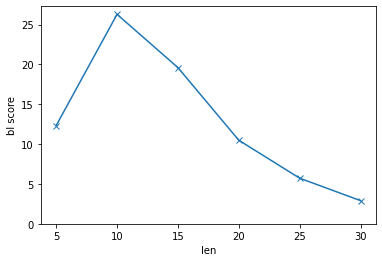

In [ ]:
rnn_len_threshold, rnn_bin_bl = get_binned_bl_score(nmt_rnn, dataset_dict['val'])

As we work with a small training data, you see this drop in BLEU score for sentences of shorter length. We don't have enough data points with small sentence length.

---
### Model Extension: RNN Encoder + Source Side Attention

*Attention* addresses to the vanishing gradient problem and the limit of fixed_size representation of the input. We use a *context vector* for implementing attention.

- Context Vector $c_i$ gives the additional information from source side for *decoding* the next token.
  - $i$ : time step in *decoder*
  - $j$ : time step in *encoder*
  - $s_i$ : hidden state at $i^{th}$ time step
  - $y_i$ : output word at $i^{th}$ time step
  - $\alpha_{ij}$ : attention weight, $\alpha_{ij} \geq 0$ and $\sum{\alpha_{ij}} = 1$
  - $h_j$ : intermediate state of encoder at time step $j$
$$s_i = f(s_{i-1}, y_{i-1}, c_i)$$
$$ c_t = \sum_{j=1}^{T(x)}\alpha_{ij} h_j$$

- How to fit context vector into decoding framework: <br>
    a) Initiaze with 0 <br>
    b) input to RNN is the concatenation of the input token and context vector <br>

- How to compute the attention?
  One way could be using *Softmax*. See the code of `Attention_Module` in `nnet_models_new.py`.


In [ ]:
encoder_attention = True
self_attention = False

In [ ]:
encoder_encoderattn = nnet_models_new.EncoderRNN(source_vocab, hidden_size, 1)

In [ ]:
decoder_encoderattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)

In [ ]:
nmt_encoderattn = nnet_models_new.seq2seq(encoder_encoderattn, decoder_encoderattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_again = False
modelname = 'encoderattn'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_encoderattn = torch.load(get_full_filepath(saved_models_dir, modelname))
else:
    train_model(dataloader_dict, nmt_encoderattn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'encoderattn_test')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRUCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Mo

#### Model Performance

In [ ]:
print(nmt_encoderattn.get_bleu_score(dataloader_dict['val']))

38.679602311519936


#### BLEU vs Sentence Length

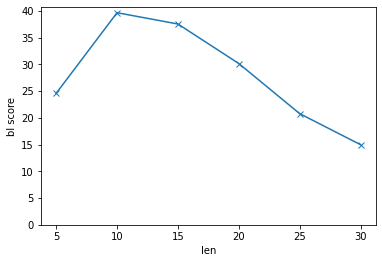

In [ ]:
attn_len_threshold, attn_bin_bl = get_binned_bl_score(nmt_encoderattn, dataset_dict['val'])

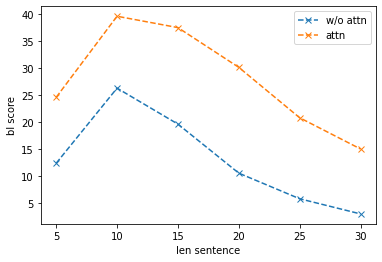

In [ ]:
plt.plot(rnn_len_threshold, rnn_bin_bl, '--x', label = 'w/o attn')
plt.plot(attn_len_threshold, attn_bin_bl, '--x', label = 'attn')
plt.xlabel('len sentence')
plt.ylabel('bl score')
plt.legend()

#### Interacting with the system

souce:  hello how are you ?
prediction:  ne t a pas grand si ?
GT on sentence (src->tgt):  salut comment allez-vous ?
GT on prediction (tgt->src):  isn't that big, is it?


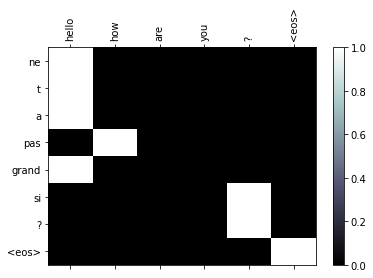

In [ ]:
get_translation(nmt_encoderattn, 'hello how are you ?', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle sait mieux que de ne pas le disputer avec lui .
GT on sentence (src->tgt):  elle sait mieux que de discuter avec lui.
GT on prediction (tgt->src):  she knows better than not to argue with him.


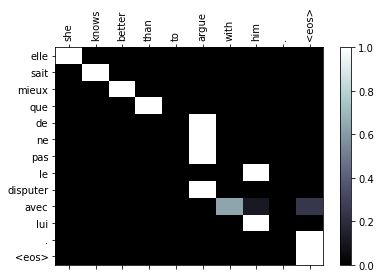

In [ ]:
get_translation(nmt_encoderattn, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  she s five years years than me .
prediction:  elle a cinq ans de moi que moi .
GT on sentence (src->tgt):  elle a cinq ans que moi.
GT on prediction (tgt->src):  she is five years from me than me.


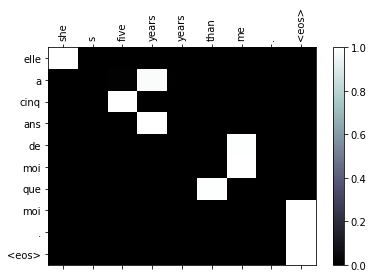

In [ ]:
get_translation(nmt_encoderattn, 'she s five years years than me .', source_lang_obj, use_cuda)